# Initialization

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.functions import mean, col, desc, count, isnull, isnan, when, rank, sum
import pandas as pd
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.ui.showConsoleProgress", "false") \
    .getOrCreate()
    # .config("spark.master", "spark://127.0.0.1:7077") \


spark.sparkContext.setLogLevel(logLevel='ERROR')

uber_file = "uber-raw-data-aug14.csv"

uber = spark.read.csv(uber_file, header=True, inferSchema=True)


# Data cleaning

## Duplicate values

In [2]:
uber_count = uber.count()
print('Number of rows:', uber_count)

uber = uber.distinct()
uber_count_distinct = uber.count()
print('Number of dinstinct rowns:', uber_count_distinct)
print('Removed {} duplicate rows'.format(uber_count - uber_count_distinct))

Number of rows: 829275
Number of dinstinct rowns: 813393
Removed 15882 duplicate rows


## Outliers

![outliers](outliers.png)

In [3]:
pdf = uber.toPandas()


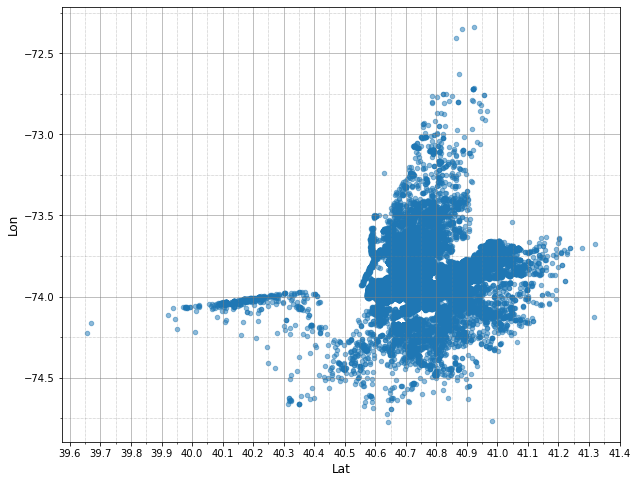

In [4]:
ax = pdf.plot(kind='scatter', x='Lat', y='Lon', alpha=0.5, figsize=(10,8))

ax.set_xlabel('Lat', fontsize=12)
ax.set_ylabel('Lon', fontsize=12)

ax.xaxis.set_major_locator(plt.MaxNLocator(21))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_minor_locator(plt.MaxNLocator(41))
ax.yaxis.set_minor_locator(plt.MaxNLocator(11))

ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')

plt.show()


In [5]:
tdf = uber.filter(col('Lat') > 39.7)
tdf = tdf.filter(col('Lon') < -72.5)
tdf = tdf.filter(col('Lat') < 41.25)
tdf = tdf.filter(~((col('Lon') > -73.25) & (col('Lat') < 40.65)))
tdf = tdf.filter(~((col('Lon') < -74.75) & (col('Lat') > 40.95)))
tdf = tdf.filter(~((col('Lon') > -73.56) & (col('Lat') > 41.03)))
# tdf.sort(col('Lat').desc()).show()

uber = tdf


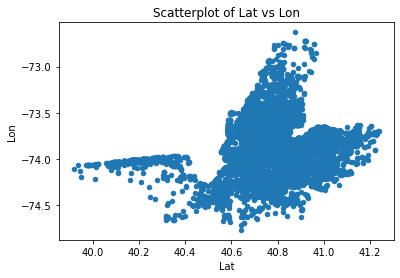

In [6]:
pdf = uber.toPandas()
pdf.plot.scatter(x='Lat', y='Lon') #, figsize=(4.32, 2.88), s=10)
plt.title(f'Scatterplot of Lat vs Lon')
plt.show()

# print(plt.gcf().get_size_inches())


In [7]:
clean_uber_count = uber.count()
print('Number of rows:', clean_uber_count)
print('Removed {} outliers'.format(uber_count_distinct - clean_uber_count))


Number of rows: 813382
Removed 11 outliers


# Data preperation

## VectorAssembler

In [8]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['Lat', 'Lon'], outputCol="vector_features")
uber = assembler.transform(uber)
uber.show()


+-----------------+-------+--------+------+------------------+
|        Date/Time|    Lat|     Lon|  Base|   vector_features|
+-----------------+-------+--------+------+------------------+
| 8/1/2014 6:58:00| 40.724|-73.9783|B02512| [40.724,-73.9783]|
|8/1/2014 11:47:00| 40.774|-73.8726|B02512| [40.774,-73.8726]|
|8/1/2014 12:39:00|40.7123|-73.9954|B02512|[40.7123,-73.9954]|
|8/1/2014 13:04:00|40.7662| -73.968|B02512| [40.7662,-73.968]|
|8/1/2014 14:29:00|40.7609|-73.9872|B02512|[40.7609,-73.9872]|
|8/1/2014 16:51:00|40.7573|-73.9821|B02512|[40.7573,-73.9821]|
|8/1/2014 18:54:00|40.7565|-73.9739|B02512|[40.7565,-73.9739]|
|8/1/2014 20:49:00| 40.743| -74.008|B02512|  [40.743,-74.008]|
|8/1/2014 22:38:00|40.7281|-73.9791|B02512|[40.7281,-73.9791]|
|8/1/2014 23:21:00|40.6842|-73.9993|B02512|[40.6842,-73.9993]|
| 8/2/2014 0:45:00|40.7501|-74.0025|B02512|[40.7501,-74.0025]|
|8/2/2014 16:56:00|40.7126|-73.9589|B02512|[40.7126,-73.9589]|
|8/3/2014 12:24:00|40.7186|-73.9548|B02512|[40.7186,-73

## Normalization

In [9]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='vector_features', outputCol='vector_features_std')
scaler_model = scaler.fit(uber)
uber = scaler_model.transform(uber)

uber.show()


+-----------------+-------+--------+------+------------------+--------------------+
|        Date/Time|    Lat|     Lon|  Base|   vector_features| vector_features_std|
+-----------------+-------+--------+------+------------------+--------------------+
| 8/1/2014 6:58:00| 40.724|-73.9783|B02512| [40.724,-73.9783]|[937.414247478661...|
|8/1/2014 11:47:00| 40.774|-73.8726|B02512| [40.774,-73.8726]|[938.565183348761...|
|8/1/2014 12:39:00|40.7123|-73.9954|B02512|[40.7123,-73.9954]|[937.144928485058...|
|8/1/2014 13:04:00|40.7662| -73.968|B02512| [40.7662,-73.968]|[938.385637353025...|
|8/1/2014 14:29:00|40.7609|-73.9872|B02512|[40.7609,-73.9872]|[938.263638150795...|
|8/1/2014 16:51:00|40.7573|-73.9821|B02512|[40.7573,-73.9821]|[938.180770768148...|
|8/1/2014 18:54:00|40.7565|-73.9739|B02512|[40.7565,-73.9739]|[938.162355794226...|
|8/1/2014 20:49:00| 40.743| -74.008|B02512|  [40.743,-74.008]|[937.851603109299...|
|8/1/2014 22:38:00|40.7281|-73.9791|B02512|[40.7281,-73.9791]|[937.508624220

# KMeans

## Find best K

In [10]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


costs = []
silhouette_score = []
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='vector_features_std',
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
predictions_list = []
seed = 383
for i in range(2, 11):
    kmeans = KMeans(featuresCol='vector_features_std', k=i, seed=seed)
    model = kmeans.fit(uber)
    predictions = model.transform(uber)
    predictions_list.append(predictions)
    print("K:", i, "--------------------")
    
    score=evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print("Silhouette score: %.2f" % score)

    cost = model.summary.trainingCost # model.computeCost(uber) is removed from Spark
    costs.append(cost)
    print("Cost: {:,}".format(int(cost)))


K: 2 --------------------
Silhouette score: 0.38
Cost: 1,247,982
K: 3 --------------------
Silhouette score: 0.44
Cost: 1,041,427
K: 4 --------------------
Silhouette score: 0.55
Cost: 689,292
K: 5 --------------------
Silhouette score: 0.50
Cost: 633,462
K: 6 --------------------
Silhouette score: 0.55
Cost: 535,124
K: 7 --------------------
Silhouette score: 0.52
Cost: 453,642
K: 8 --------------------
Silhouette score: 0.42
Cost: 404,641
K: 9 --------------------
Silhouette score: 0.41
Cost: 376,123
K: 10 --------------------
Silhouette score: 0.45
Cost: 316,112


### Evaluation

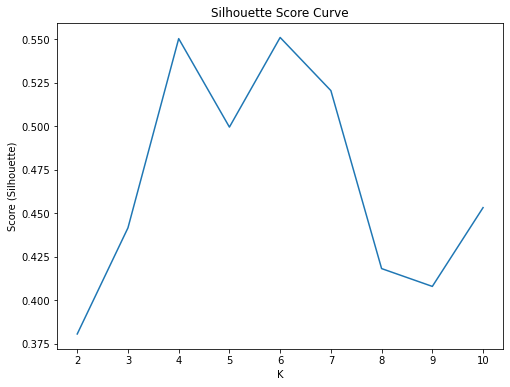

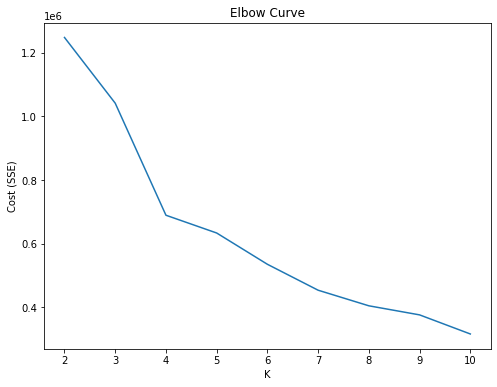

In [11]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),silhouette_score)
ax.set_xlabel('K')
ax.set_ylabel('Score (Silhouette)')
ax.set_title('Silhouette Score Curve')
plt.show()

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),costs)
ax.set_xlabel('K')
ax.set_ylabel('Cost (SSE)')
ax.set_title('Elbow Curve')
plt.show()


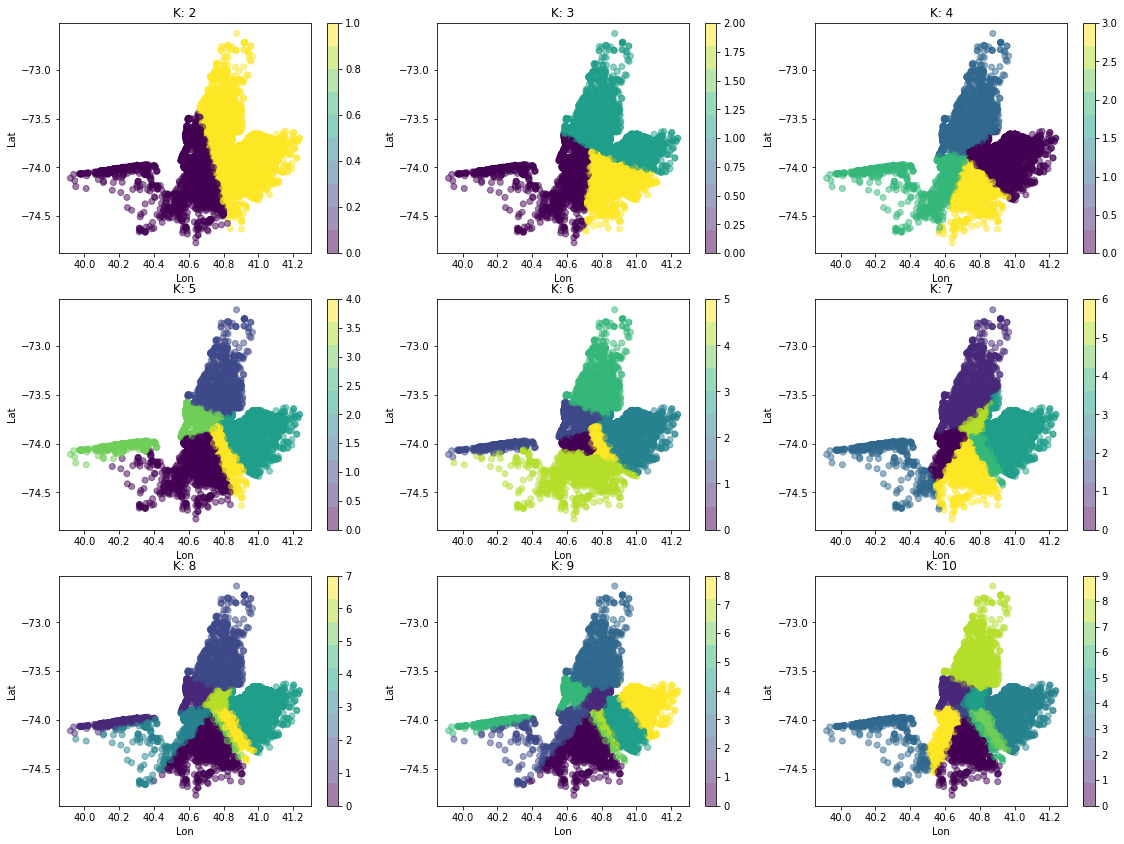

In [12]:
plt.figure(figsize=(6.4*3, 4.8*3))

for index, p in enumerate(predictions_list):
    # predictions.select('prediction').distinct().show()
    pdf = p.select(col("Lat"), col("Lon"), col("prediction")).toPandas()
    cmap = plt.cm.get_cmap("viridis", 10)

    plt.subplot(3, 3, index + 1)
    plt.scatter(x=pdf['Lat'], y=pdf['Lon'], c=pdf['prediction'], cmap=cmap, alpha=0.5)
    plt.colorbar()
    plt.title("K: " + f"{index + 2}")
    plt.xlabel("Lon")
    plt.ylabel("Lat")

plt.show()


In [13]:
# K = silhouette_score.index(max(silhouette_score)) + 2
# print('Best K: {}'.format(K))
K = 4


# Split data

In [14]:
# Split data to 80 and 20 percents
train, test = uber.randomSplit([0.8, 0.2])
print("Training dataset count: " + str(train.count()))
print("Test dataset count: " + str(test.count()))

kmeans = KMeans(featuresCol="vector_features", k=K, seed=seed)
model = kmeans.fit(train)
predictions = model.transform(train)
predictions.show(5)

evaluator = ClusteringEvaluator(featuresCol='vector_features_std')
silhouette_score = evaluator.evaluate(predictions)
print("Silhouette score:", silhouette_score)


Training dataset count: 650769
Test dataset count: 162613
+----------------+-------+--------+------+------------------+--------------------+----------+
|       Date/Time|    Lat|     Lon|  Base|   vector_features| vector_features_std|prediction|
+----------------+-------+--------+------+------------------+--------------------+----------+
|8/1/2014 0:01:00|40.6718|-73.9522|B02682|[40.6718,-73.9522]|[936.212670430277...|         2|
|8/1/2014 0:01:00|40.7341| -73.989|B02617| [40.7341,-73.989]|[937.646736524422...|         2|
|8/1/2014 0:02:00|40.8656|-73.9274|B02598|[40.8656,-73.9274]|[940.673697862783...|         1|
|8/1/2014 0:03:00|40.6701|-73.9899|B02617|[40.6701,-73.9899]|[936.173538610694...|         2|
|8/1/2014 0:03:00|40.6748|-73.9815|B02598|[40.6748,-73.9815]|[936.281726582483...|         2|
+----------------+-------+--------+------+------------------+--------------------+----------+
only showing top 5 rows

Silhouette score: 0.4541467323174956


## Split visualization

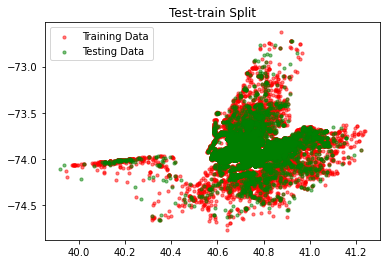

In [15]:
plt.scatter(train.select('Lat').toPandas(), train.select('Lon').toPandas(), label='Training Data', color='r', alpha=.5, s=10)
plt.scatter(test.select('Lat').toPandas(), test.select('Lon').toPandas(), label='Testing Data', color='g', alpha=.5, s=10)
plt.legend()
plt.title('Test-train Split')
plt.show()


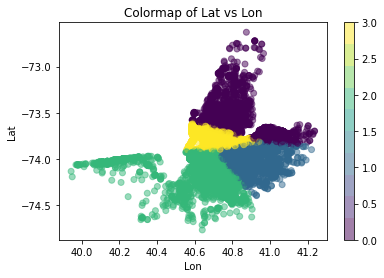

In [16]:
pdf = predictions.select(col("Lat"), col("Lon"), col("prediction")).toPandas()
cmap = plt.cm.get_cmap("viridis", 10)

plt.scatter(x=pdf['Lat'], y=pdf['Lon'], c=pdf['prediction'], cmap=cmap, alpha=0.5)
plt.colorbar()
plt.title("Colormap of Lat vs Lon")
plt.xlabel("Lon")
plt.ylabel("Lat")
plt.show()


# Save test split

In [17]:
# as csv
udf = test.select('Date/Time', 'Lat', 'Lon', 'Base').toDF('Date/Time', 'Lat', 'Lon', 'Base')
udf.write.csv('uber_test_split', mode='overwrite')

pdf = udf.toPandas()
pdf.to_csv('uber_test_split.csv', index=False)


# as json
test_list = test.toJSON().collect()

import json

with open('uber_test_split.json', 'w') as fd:
    json.dump(test_list, fd)


# Save model

In [18]:
# model.save("uber_kmeans_model")
model.write().overwrite().save("uber_kmeans_model")


# Load model

<p dir=rtl>برای لود کردن مدل باید حتماً از کلاس KMeansModel استفاده کنیم و اگر از کلاس KMeans استفاده کنیم خطا خواهد داد.</>

In [ ]:
from pyspark.ml.clustering import KMeansModel
model = KMeansModel.load("uber_kmeans_model")


# Consumer

In [19]:
from kafka import KafkaConsumer
from pyspark.sql.types import StructType, StructField, TimestampType, IntegerType
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import to_timestamp

schema = StructType([
    StructField("Date/Time", StringType(), True),
    StructField("Lat", DoubleType(), True),
    StructField("Lon", DoubleType(), True),
    StructField("Base", StringType(), True)
])

schema_final = StructType([
    StructField("Date/Time", StringType(), True),
    StructField("Lat", DoubleType(), True),
    StructField("Lon", DoubleType(), True),
    StructField("Base", StringType(), True),
    StructField("vector_features", VectorUDT(), True),
    StructField("vector_features_std", VectorUDT(), True),
    StructField("prediction", IntegerType(), True),
])

consumer = KafkaConsumer('uber', bootstrap_servers=['127.0.0.1:9092']) #, max_poll_records=100, group_id='uber_group')


## Immediate processing

In [21]:
msgs = []
for msg in consumer:
    msgs.append(msg)
    data = msg.value.decode('utf-8').split(',')
    data_converted = data[0], float(data[1]), float(data[2]), data[3].strip()
    df1 = spark.createDataFrame([data_converted], schema=schema)
    assembler = VectorAssembler(inputCols=['Lat', 'Lon'], outputCol="vector_features")
    df2 = assembler.transform(df1)
    df3 = scaler_model.transform(df2)
    df4 = model.transform(df3)
    result = df4.select('prediction').collect()[0].prediction
    print(f'Prediction for {data_converted} is {result}')
    if len(msgs) == 10:
        break
    

Prediction for ('8/17/2014 11:52:00', 40.7363, -74.0076, 'B02682') is 2
Prediction for ('8/25/2014 21:47:00', 40.7437, -74.0034, 'B02617') is 2
Prediction for ('8/31/2014 17:23:00', 40.7615, -73.9664, 'B02682') is 1
Prediction for ('8/4/2014 18:49:00', 40.6781, -73.8259, 'B02598') is 3
Prediction for ('8/19/2014 9:59:00', 40.6768, -74.0135, 'B02598') is 2
Prediction for ('8/10/2014 18:13:00', 40.7339, -73.9867, 'B02682') is 2
Prediction for ('8/31/2014 19:31:00', 40.7336, -73.9565, 'B02617') is 1
Prediction for ('8/3/2014 16:02:00', 40.8797, -73.9178, 'B02598') is 1
Prediction for ('8/23/2014 22:12:00', 40.7142, -73.9652, 'B02598') is 2
Prediction for ('8/13/2014 16:55:00', 40.7873, -73.9717, 'B02598') is 1


## Batch processing

In [22]:
df_final = spark.createDataFrame([], schema=schema_final)

msgs = []
for msg in consumer:
    msgs.append(msg)
    print(f'\r{len(msgs)}', end='')
    data = msg.value.decode('utf-8').split(',')
    data_converted = data[0], float(data[1]), float(data[2]), data[3].strip()
    df1 = spark.createDataFrame([data_converted], schema=schema)
    assembler = VectorAssembler(inputCols=['Lat', 'Lon'], outputCol="vector_features")
    df2 = assembler.transform(df1)
    df3 = scaler_model.transform(df2)
    df4 = model.transform(df3)
    df_final = df_final.union(df4)
    if len(msgs) == 1000: # 162698
        break
    

1000

In [23]:
df_final.show()


+------------------+-------+--------+------+------------------+--------------------+----------+
|         Date/Time|    Lat|     Lon|  Base|   vector_features| vector_features_std|prediction|
+------------------+-------+--------+------+------------------+--------------------+----------+
|8/29/2014 14:29:00|40.7213|-73.9797|B02598|[40.7213,-73.9797]|[937.352096941676...|         2|
| 8/27/2014 6:56:00|40.7527|-74.0042|B02682|[40.7527,-74.0042]|[938.074884668098...|         1|
|8/22/2014 11:20:00|40.7603|-73.9595|B02598|[40.7603,-73.9595]|[938.249826920354...|         1|
| 8/7/2014 23:35:00|40.7048|-74.0123|B02682|[40.7048,-74.0123]|[936.972288104543...|         2|
|8/25/2014 14:23:00|40.7285|-73.9789|B02598|[40.7285,-73.9789]|[937.517831706970...|         2|
| 8/8/2014 21:00:00|40.7292|-73.9782|B02617|[40.7292,-73.9782]|[937.533944809152...|         2|
|8/18/2014 10:16:00| 40.725|-73.8538|B02617| [40.725,-73.8538]|[937.437266196063...|         3|
|8/19/2014 11:42:00|40.7383|-73.9969|B02

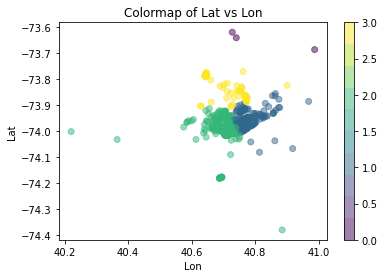

In [24]:
pdf = df_final.select(col("Lat"), col("Lon"), col("prediction")).toPandas()
cmap = plt.cm.get_cmap("viridis", 10)

plt.scatter(x=pdf['Lat'], y=pdf['Lon'], c=pdf['prediction'], cmap=cmap, alpha=0.5)
plt.colorbar()
plt.title("Colormap of Lat vs Lon")
plt.xlabel("Lon")
plt.ylabel("Lat")
plt.show()
